In [1]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
# warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 80
# plt.rcParams['axes.grid'] = True
# sns.set()


In [2]:
import sys
sys.path.insert(0, '..')
from synthesizer import Synthesizer
from generator import Generator
from algorithm import Algorithm


from hypers import weight_hypers
from hypers import alpha_hypers
from draw import draw_all

In [3]:
series_type = "default"
from_start = False
a, b = -40, 40
train_window = 10

# Cоздание синтезатора, cпособного создавать workers_num наборов параметров, для каждого из которых генерировать временные ряды.
# Сигнал - случайный вектор из нормального распределения. Отклик - скалярное произведение сигнала на вектор весов плюс нормальный шум из N(0,1)
synt = Synthesizer(series_type, dim=10, low=-10, high=10, clip=(a, b),
                   noise_var=1, workers_num=3, random_seed=11)

# Создание генератора данных, склеивающего разнородные временные ряды в один 
# В данном случае источник рядов - наш синтезатор
gen = Generator(series_type, synt)

# Получение итогового временного ряда путем получения от синтезатора pieces_num временных рядов 
# произвольного размера из [lower_bound, upper_bound) и их последующей склейки
gen.generate(length=1500, from_start=from_start, lower_bound=75, upper_bound=300, alternating=True)


In [4]:
# gen.show_time_series()

In [5]:
# gen.draw_merged()

In [6]:
gen.launch()
algo0 = Algorithm(series_type, gen, train_window=train_window, a=a, b=b, init_pretrained=False)
algo0.run()
algo0.post_calculations(from_start=from_start)

wh = weight_hypers["simple_101"]

gen.launch()
algo1 = Algorithm(series_type, gen, train_window=train_window, a=a, b=b, 
                 weights_func=wh.func, weight_const=wh.const, init_pretrained=False)
algo1.run()
algo1.post_calculations(from_start=from_start)

100%|████████████████████████████████████████████████████████████████████████| 2149/2149 [00:45<00:00, 47.49it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


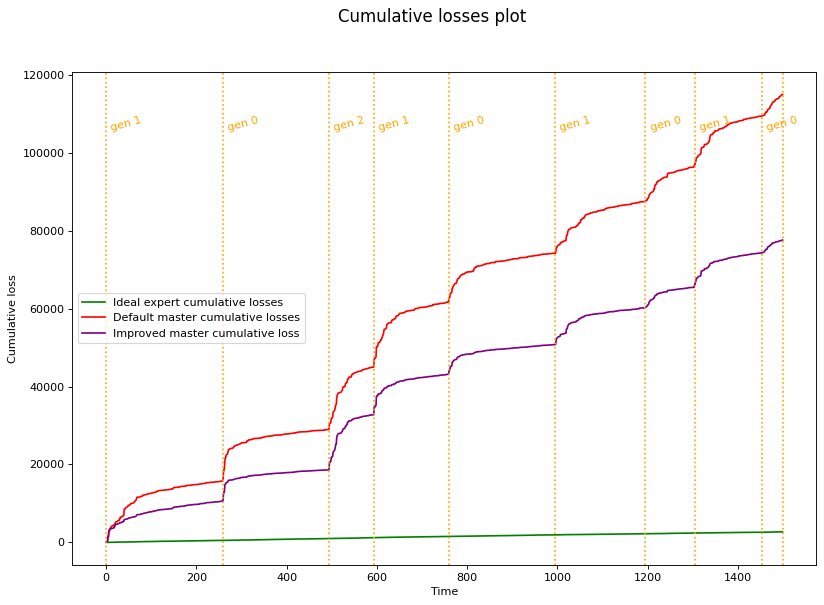

In [9]:
draw_more(algo0, show=["master", "ideal"], show_experts=[], show_axes=["regret"], height_ratios=[1], 
                  suptitle=f"Cumulative losses plot", fig_size=(12, 8), 
                  other=[algo1.master_losses_all], labels=["Improved master cumulative loss"], colors=['purple'], loc='center left')


In [8]:
def draw_more(logs, show=None, show_experts=None,
             show_axes=None, height_ratios=None, suptitle=None, fig_size=(15, 10), other=None, labels=None, colors=None, loc='upper left'):

    if show is None:
        show = ["master"]
    if show_experts is None:
        show_experts = []
    if show_axes is None:
        show_axes = ["regret"]
    if height_ratios is None:
        height_ratios = [1 for _ in show_axes]
    if suptitle is None:
        suptitle = "Algorithm"
    assert len(show_axes) == len(height_ratios), "Wrong sizes"
    if other is None:
        other = []
        labels = []
        colors=[]
    

    text_idx = 0

    fig, axes = plt.subplots(len(show_axes), 1, figsize=fig_size, sharex=True, height_ratios=height_ratios)
    ax = [axes] if len(show_axes) == 1 else axes
    grid = np.arange(logs.total_time - logs.shift)

    try:
        idx = show_axes.index("loss")
        text_idx = idx

        if "ideal" in show:
            ax[idx].plot(grid, logs.ideal_losses[logs.shift:], label="Ideal expert losses",
                         color='green')
        if "zero" in show:
            ax[idx].plot(grid, logs.zero_losses[logs.shift:],
                         label="Zero expert losses",
                         color='yellow')
        for expert_num in show_experts:
            ax[idx].plot(grid, logs.experts_losses_all.T[expert_num][logs.shift:],
                         label=f"Expert {expert_num} losses")
        if "master" in show:
            ax[idx].plot(grid, logs.master_losses_all[logs.shift:], label="Master losses",
                         color='red')

        ax[idx].set_ylabel("Loss")
        ax[idx].legend()

    except ValueError:
        pass

    try:
        idx = show_axes.index("regret")

        if "ideal" in show:
            ax[idx].plot(grid, logs.ideal_losses[logs.shift:].cumsum(),
                         label="Ideal expert cumulative losses", color='green')
        if "zero" in show:
            ax[idx].plot(grid, logs.zero_losses[logs.shift:].cumsum(),
                         label="Zero expert cumulative losses", color='yellow')

        for expert_num in show_experts:
            ax[idx].plot(grid, logs.experts_losses_all.T[expert_num][logs.shift:].cumsum(),
                         label=f"Expert {expert_num} cumulative losses")

        if "master" in show:
            ax[idx].plot(grid, logs.master_losses_all[logs.shift:].cumsum(),
                         label="Default master cumulative losses", color='red')

        if "theoretical" in show:
            ax[idx].plot(grid, logs.theoretical_upper[logs.shift:],
                         label="Theoretical upper bound", color='black')
        for another, label, color in zip(other, labels, colors):
            ax[idx].plot(grid, another[logs.shift:].cumsum(),
                             label=label, color=color)
        

        ax[idx].set_xlabel("Time")
        ax[idx].set_ylabel("Cumulative loss")
        ax[idx].legend(loc=loc)

    except ValueError:
        pass

    bottom, top = ax[text_idx].get_ybound()
    left, right = ax[text_idx].get_xbound()
    for gen_idx, gen_stamp in zip(np.r_[logs.indexes, -1], logs.stamps):
        if gen_stamp < logs.shift:
            continue
        for i in range(len(show_axes)):
            ax[i].axvline(gen_stamp - logs.shift, color='orange', linestyle=':')
        if gen_idx != -1:
            ax[text_idx].text(x=gen_stamp - logs.shift + 0.005 * (right - left), y=top - 0.12 * (top - bottom),
                              s=f"gen {gen_idx}", color='orange', rotation=15)

    fig.suptitle(suptitle, fontsize=15)
    # plt.savefig('../results/impovement.png')
    plt.savefig('../results/improvement3.eps', format='eps')
    plt.show()
   